# Imports

In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading in the Data

In [6]:
# Reading in the data

DIR = "../../data/"
DATA = "bike-sharing-daily.csv"
day_bike_rentals = pd.read_csv(DIR+DATA)
day_bike_rentals.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Data Cleaning

## Categorical Features

In [7]:
# Label Lists

weekdays = ['SUN', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT']
holidays = ['NO HOLIDAY', 'HOLIDAY']
working_day = ['NO WORKING DAY', 'WORKING DAY']
season = ['WINTER', 'SPRING', 'SUMMER', 'FALL']
weathersit = ['GOOD', 'MISTY', 'RAIN/SNOW/STORM']
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

In [8]:
# Function to create a dictionary mapping index of list to the respective label

def create_dictionary(label_list, start_at_zero=True):
  d = {}
  if start_at_zero:
    for idx, val in enumerate(label_list):
      d[idx] = val
  else:
    for idx, val in enumerate(label_list):
      d[idx+1] = val
  return d

In [9]:
# Mapping the indicies to actual labels

day_bike_rentals['weekday'] = day_bike_rentals['weekday'].map(create_dictionary(weekdays))
day_bike_rentals['holiday'] = day_bike_rentals['holiday'].map(create_dictionary(holidays))
day_bike_rentals['workingday'] = day_bike_rentals['workingday'].map(create_dictionary(working_day))
day_bike_rentals['season'] = day_bike_rentals['season'].map(create_dictionary(season, start_at_zero=False))
day_bike_rentals['weathersit'] = day_bike_rentals['weathersit'].map(create_dictionary(weathersit, start_at_zero=False))
day_bike_rentals['mnth'] = day_bike_rentals['mnth'].map(create_dictionary(months, start_at_zero=False))

## Numerical Features

In [10]:
# Denormalizing the temperture

# Function that denormalizes temperture
def inverse_min_max(row, tmin, tmax):
  return row * (tmax - tmin) + tmin

# t_min=-8, t_max=+39
day_bike_rentals['temp'] = day_bike_rentals['temp'].apply(inverse_min_max, args=(-8, 39))

# t_min=-16, t_max=+50
day_bike_rentals['atemp'] = day_bike_rentals['atemp'].apply(inverse_min_max, args=(-16, 50))

In [11]:
# DeNormalized wind speed. The values are divided by 67 (max)

day_bike_rentals['windspeed'] = day_bike_rentals['windspeed'].apply(lambda row: row * 67)

In [12]:
# Dormalized humidity. The values are divided by 100 (max)

day_bike_rentals['hum'] = day_bike_rentals['hum'].apply(lambda row: row * 100)

## Temporal Features

In [13]:
# Processing time features

day_bike_rentals['yr'] = day_bike_rentals['yr'].apply(lambda row: 2011 if row == 0 else 2012)
day_bike_rentals['dteday'] = pd.to_datetime(day_bike_rentals['dteday'])
day_bike_rentals['days_since_2011'] = (day_bike_rentals['dteday'] - day_bike_rentals['dteday'].min()).dt.days

# Data Processing

In [108]:
# Extracting only the needed features

day_bike_rentals = day_bike_rentals[[col for col in day_bike_rentals.columns if col not in ['instant', 'dteday', 'registered', 'casual', 'atemp']]]

## Dummifying Categorical Features

In [109]:
# Collecting only the categorical features

categorical_features = [col for col in day_bike_rentals.columns if day_bike_rentals[col].dtype == 'object']
categorical_features

['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

In [110]:
# Collecting all the features that needs to be dummified 
sub_features = ['season', 'holiday','workingday', 'weathersit']
sub_features

['season', 'holiday', 'workingday', 'weathersit']

In [111]:
# Dummifying categorical features
cleaned_bike_data = pd.concat([day_bike_rentals, pd.get_dummies(day_bike_rentals[sub_features], drop_first=True)], axis=1)

# Dropping unnecessary columns
bike = cleaned_bike_data.drop(sub_features + ['yr', 'mnth', 'weekday'], axis=1)

# Viewing the result
bike.head()

,temp,hum,windspeed,cnt,days_since_2011,season_SPRING,season_SUMMER,season_WINTER,holiday_NO HOLIDAY,workingday_WORKING DAY,weathersit_MISTY,weathersit_RAIN/SNOW/STORM
0,8.175849,80.5833,10.749882,985,0,0,0,1,1,0,1,0
1,9.083466,69.6087,16.652113,801,1,0,0,1,1,0,1,0
2,1.229108,43.7273,16.636703,1349,2,0,0,1,1,1,0,0
3,1.400000,59.0435,10.739832,1562,3,0,0,1,1,1,0,0
4,2.666979,43.6957,12.522300,1600,4,0,0,1,1,1,0,0


In [18]:
bike.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,731.0,15.283085,8.603397,-5.220871,7.842925,15.421651,22.804575,32.498349
hum,731.0,62.789406,14.242910,0.000000,52.000000,62.666700,73.020850,97.250000
windspeed,731.0,12.762576,5.192357,1.500244,9.041650,12.125325,15.625371,34.000021
cnt,731.0,4504.348837,1937.211452,22.000000,3152.000000,4548.000000,5956.000000,8714.000000
days_since_2011,731.0,365.000000,211.165812,0.000000,182.500000,365.000000,547.500000,730.000000
season_SPRING,731.0,0.251710,0.434293,0.000000,0.000000,0.000000,1.000000,1.000000
season_SUMMER,731.0,0.257182,0.437380,0.000000,0.000000,0.000000,1.000000,1.000000
season_WINTER,731.0,0.247606,0.431917,0.000000,0.000000,0.000000,0.000000,1.000000
holiday_NO HOLIDAY,731.0,0.971272,0.167155,0.000000,1.000000,1.000000,1.000000,1.000000
workingday_WORKING DAY,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000


In [ ]:
def data_pipeline():
    
    # Reading in the data
    day_bike_rentals = pd.read_csv(DIR+DATA)
    
    # Mapping numerical codes with actual values
    day_bike_rentals['weekday'] = day_bike_rentals['weekday'].map(create_dictionary(weekdays))
    day_bike_rentals['holiday'] = day_bike_rentals['holiday'].map(create_dictionary(holidays))
    day_bike_rentals['workingday'] = day_bike_rentals['workingday'].map(create_dictionary(working_day))
    day_bike_rentals['season'] = day_bike_rentals['season'].map(create_dictionary(season, start_at_zero=False))
    day_bike_rentals['weathersit'] = day_bike_rentals['weathersit'].map(create_dictionary(weathersit, start_at_zero=False))
    day_bike_rentals['mnth'] = day_bike_rentals['mnth'].map(create_dictionary(months, start_at_zero=False))
    
    # Reversing min_max
    day_bike_rentals['temp'] = day_bike_rentals['temp'].apply(inverse_min_max, args=(-8, 39))
    day_bike_rentals['atemp'] = day_bike_rentals['atemp'].apply(inverse_min_max, args=(-16, 50))
    
    # Unnormalizing the data
    day_bike_rentals['windspeed'] = day_bike_rentals['windspeed'].apply(lambda row: row * 67)
    day_bike_rentals['hum'] = day_bike_rentals['hum'].apply(lambda row: row * 100)
    
    # Converting labels into actual year
    day_bike_rentals['yr'] = day_bike_rentals['yr'].apply(lambda row: 2011 if row == 0 else 2012)
    
    # Converting 'dteday' to datetime object
    day_bike_rentals['dteday'] = pd.to_datetime(day_bike_rentals['dteday'])

    # Calculating days since 2011
    day_bike_rentals['days_since_2011'] = (day_bike_rentals['dteday'] - day_bike_rentals['dteday'].min()).dt.days
    
    # Feature selecting
    day_bike_rentals = day_bike_rentals[[col for col in day_bike_rentals.columns if col not in ['instant', 'dteday', 'registered', 'casual', 'atemp']]]
    
    # Dummifying categorical features
    day_bike_rentals = pd.concat([day_bike_rentals, pd.get_dummies(day_bike_rentals[sub_features], drop_first=True)], axis=1)
    
    # Returning the cleaned data
    return day_bike_rentals    

In [19]:
ef_bike = day_bike_rentals[[col for col in day_bike_rentals.columns if col not in ['instant', 'dteday', 'registered', 'casual', 'atemp']]]
ef_bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


In [20]:
ef_bike.nunique()

season               4
yr                   2
mnth                12
holiday              2
weekday              7
workingday           2
weathersit           3
temp               499
hum                595
windspeed          650
cnt                696
days_since_2011    731
dtype: int64

In [21]:
ef_bike['weathersit'].value_counts()

GOOD               463
MISTY              247
RAIN/SNOW/STORM     21
Name: weathersit, dtype: int64

In [22]:
df_bike = pd.get_dummies(ef_bike['weathersit'], drop_first=True)

# Splitting the Data

In [23]:
df_bike.shape

(731, 2)

In [24]:
# Training data

X = bike[[col for col in bike.columns if col != 'cnt']]
y = bike['cnt']

In [25]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [26]:
print(f"Dummy coeficients: {lr.coef_}, Dummy intercept: {lr.intercept_}")

Dummy coeficients: [  110.70958159   -17.37719923   -42.51347178     4.92643186
   473.71530337  -287.38742028  -425.60285274   686.11544159
   124.92093811  -379.39852979 -1901.53991489], Dummy intercept: 2138.9296219985613


## Effect Coding

In [27]:
# Converting numerical values to type int64
''' 
    Currently it is int8 and int8 cannot interpret negative values 
'''

df_bike = df_bike.astype(int)
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   MISTY            731 non-null    int64
 1   RAIN/SNOW/STORM  731 non-null    int64
dtypes: int64(2)
memory usage: 11.5 KB


In [28]:
# Setting the reference category to -1

df_bike.loc[(df_bike['MISTY']==0) & (df_bike['RAIN/SNOW/STORM']==0),'MISTY'] = -1
df_bike.loc[(df_bike['MISTY']==-1) & (df_bike['RAIN/SNOW/STORM']==0),'RAIN/SNOW/STORM'] = -1

In [29]:
# Printing the coeficients and intercept of LR

print(f"Effect Coding coeficients: {lr.coef_}\nEffect Coding intercept: {lr.intercept_}")

Effect Coding coeficients: [  110.70958159   -17.37719923   -42.51347178     4.92643186
   473.71530337  -287.38742028  -425.60285274   686.11544159
   124.92093811  -379.39852979 -1901.53991489]
Effect Coding intercept: 2138.9296219985613


In [30]:
# Calculating effect coding

effect_of_good = lr.intercept_ - (lr.coef_[0]+lr.coef_[1])
effect_of_misty = lr.intercept_ + lr.coef_[0]
effect_of_rain = lr.intercept_ + lr.coef_[1]
print(f"Effect of 'GOOD': {effect_of_good}\nEffect of 'MISTY': {effect_of_misty}\nEffect of 'RAIN': {effect_of_rain}")

Effect of 'GOOD': 2045.5972396403506
Effect of 'MISTY': 2249.639203591673
Effect of 'RAIN': 2121.5524227636606


# Splitting Data into Train and Test Sets

In [94]:
from sklearn.model_selection import train_test_split

X = bike[[col for col in bike.columns if col != 'cnt']]
y = bike['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [95]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

scale_columns = ['temp', 'hum', 'windspeed']

for col in scale_columns:
    mms.fit(X_train[col].values.reshape(-1,1))
    X_train[col] = mms.transform(X_train[col].values.reshape(-1,1))
    X_test[col] = mms.transform(X_test[col].values.reshape(-1,1))

# Linear Regression

In [34]:
# Training the Data

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train,y_train)

print("Linear Regession")
lr.coef_

Linear Regession


array([ 4119.68595694, -1270.84325983, -1128.71029573,     4.8310698 ,
         468.29339945,  -200.30842603,  -360.94542215,   485.53541273,
          96.92766521,  -300.13333285, -1896.75540058])

In [35]:
# Evaluate the data

from sklearn.metrics import mean_squared_error

predictions = lr.predict(X_test)
print(f"MSE: {mean_squared_error(predictions, y_test)}")

MSE: 884897.294264837


# Lasso Regression

In [36]:
# Imports
from sklearn.linear_model import Lasso

# Fitting the model
lasso = Lasso(alpha=0.5)
lasso.fit(X_train, y_train)
print("Lasso Regression: ")
lasso.coef_

Lasso Regression: 


array([ 4086.18142137, -1251.03700225, -1114.61277435,     4.83844788,
         475.98848393,  -181.43877689,  -358.58597195,   465.58406442,
          96.32689137,  -301.20879631, -1885.99734402])

In [37]:
# Evaluate the data

from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(lasso.predict(X_train), y_train)
predictions = lasso.predict(X_test)

print(f"MSE: {train_mse}")
print(f"MSE: {mean_squared_error(predictions, y_test)}")

MSE: 751649.6486909935
MSE: 886927.2630415942


## Hyperparameter Tuning

In [38]:
# Using GridSearch and CV to find best alpha

lasso = Lasso()

from sklearn.model_selection import GridSearchCV

parameters = {"alpha":np.arange(.1,1.1, 0.1)}
grid_search = GridSearchCV(
    estimator=Lasso(),
    param_grid=parameters,
)

grid_search.fit(X_train, y_train)

sorted(grid_search.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_alpha',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [39]:
grid_search.best_params_['alpha']

0.1

In [40]:
lasso = Lasso(alpha=0.1)

# Fitting the model
lasso.fit(X_train, y_train)

# Calculating the train performance
train_predictions = lasso.predict(X_train)
train_mse = mean_squared_error(train_predictions, y_train)

# Calculating the test performance
test_predictions = lasso.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)

print(f"Train performance: {train_mse}, Test performance: {test_mse}")

Train performance: 751596.8213950731, Test performance: 885291.6766173533


In [41]:
lasso.coef_

array([ 4113.03486783, -1266.8947437 , -1125.89284108,     4.83253953,
         469.8202845 ,  -196.55402595,  -360.46931257,   481.54641279,
          96.80660755,  -300.34475081, -1894.59623269])

In [42]:
# Feature is line
# y: weights are weights
# x: lambda

In [43]:
# for num in np.arange(.1,1.1, 0.01):
#     print(np.log(num))

## Decision Trees

In [44]:
ef_bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


In [45]:
# Getting data

dt_columns = ['temp', 'season', 'days_since_2011','windspeed', 'hum', 'cnt']

dt_df = ef_bike[dt_columns]

### Label Encoding 'season'

In [46]:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

dt_df['labeled_season'] = le.fit_transform(dt_df['season'])

/var/folders/3h/n7g9d8x521gg4nfvf31y3_840000gn/T/ipykernel_15068/2549798644.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_df['labeled_season'] = le.fit_transform(dt_df['season'])


In [47]:
# Splitting the data into train test split

from sklearn.model_selection import train_test_split

X = dt_df[[col for col in dt_df.columns if col not in ['cnt','season']]]
y = dt_df['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [48]:
X.head()

,temp,days_since_2011,windspeed,hum,labeled_season
0,8.175849,0,10.749882,80.5833,3
1,9.083466,1,16.652113,69.6087,3
2,1.229108,2,16.636703,43.7273,3
3,1.400000,3,10.739832,59.0435,3
4,2.666979,4,12.522300,43.6957,3


In [49]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

In [50]:
dt.fit(X_train,y_train)

DecisionTreeRegressor()

In [51]:
dt.feature_importances_

array([0.22038283, 0.64386564, 0.04414508, 0.08394337, 0.00766308])

In [52]:
from sklearn import tree

dt.feature_names_in_

array(['temp', 'days_since_2011', 'windspeed', 'hum', 'labeled_season'],
      dtype=object)

In [53]:
pd.Series(dt.feature_names_in_)

0               temp
1    days_since_2011
2          windspeed
3                hum
4     labeled_season
dtype: object

In [54]:
fi_df = pd.DataFrame({'features':dt.feature_names_in_, 'importance': dt.feature_importances_}).sort_values('importance')
fi_df

,features,importance
4,labeled_season,0.007663
2,windspeed,0.044145
3,hum,0.083943
0,temp,0.220383
1,days_since_2011,0.643866


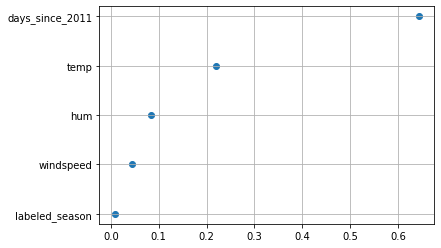

In [55]:
plt.scatter(fi_df['importance'], fi_df['features'])
plt.grid()

In [77]:
# le.inverse_transform(dt_df['labeled_season'])

In [57]:
season_map = {
    'WINTER': 1,
    'FALL': 2,
    'SPRING': 3,
    'SUMMER': 4
}

In [58]:
dt_df['my_season'] = dt_df['season'].map(season_map)
dt_df

/var/folders/3h/n7g9d8x521gg4nfvf31y3_840000gn/T/ipykernel_15068/3250286714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_df['my_season'] = dt_df['season'].map(season_map)


,temp,season,days_since_2011,windspeed,hum,cnt,labeled_season,my_season
0,8.175849,WINTER,0,10.749882,80.5833,985,3,1
1,9.083466,WINTER,1,16.652113,69.6087,801,3,1
2,1.229108,WINTER,2,16.636703,43.7273,1349,3,1
3,1.400000,WINTER,3,10.739832,59.0435,1562,3,1
4,2.666979,WINTER,4,12.522300,43.6957,1600,3,1
...,...,...,...,...,...,...,...,...
726,3.945849,WINTER,726,23.458911,65.2917,2114,3,1
727,3.906651,WINTER,727,10.416557,59.0000,3095,3,1
728,3.906651,WINTER,728,8.333661,75.2917,1341,3,1
729,4.024151,WINTER,729,23.500518,48.3333,1796,3,1


In [59]:
# Splitting the data into train test split

from sklearn.model_selection import train_test_split

X = dt_df[[col for col in dt_df.columns if col not in ['cnt','season', 'labeled_season']]]
y = dt_df['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Text(0, 0.5, 'Features')

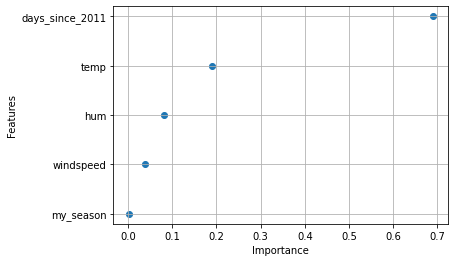

In [60]:
dt = DecisionTreeRegressor()
dt.fit(X,y)
fi_df = pd.DataFrame({'features':dt.feature_names_in_, 'importance': dt.feature_importances_}).sort_values('importance')
plt.scatter(fi_df['importance'], fi_df['features'])
plt.grid()
plt.xlabel('Importance')
plt.ylabel('Features')

On average, 70% of node purity was explained by (contributed to) 'days_since_2011'.

# Partial Dependence Plot
1. Run a model (preferably Tree model)
2. from sklearn.inspection import plot_partial_dependence

In [61]:
from sklearn.ensemble import RandomForestRegressor

In [98]:
rf = RandomForestRegressor(
    n_estimators=50,
    random_state=0
)

rf.fit(
    X_train,
    y_train,
)

RandomForestRegressor(n_estimators=50, random_state=0)

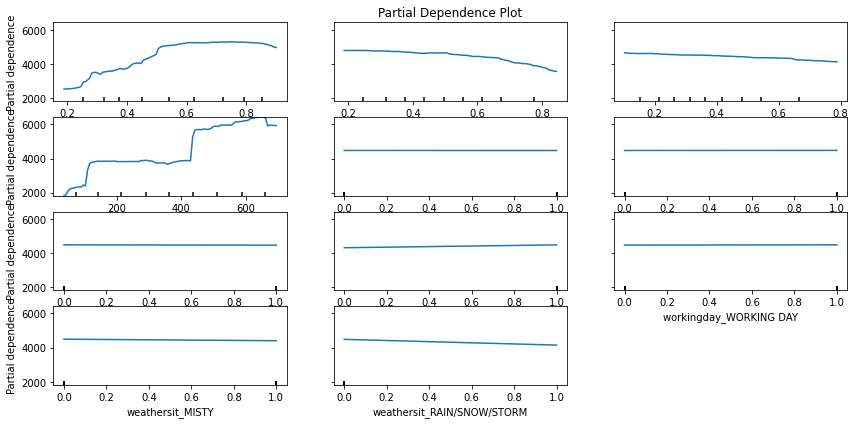

In [99]:
from sklearn.inspection import plot_partial_dependence, PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    estimator=rf,
    X=X_train,
    features=X_train.columns,
    target=y_train,
    ax=ax
)
ax.set_title("Partial Dependence Plot")
plt.tight_layout();

Temperature affects the Bike Count by:
* positively correlation from 0-15 degrees C
* levels off from 15-25 degrees C
* starts a slight dip after 25 deegrees C

Days Since 2011
* Overall positive trend
* Cyclic

Windspeed
* As wind speed increases, the bike count decreases

Humidity
* Similar to windspeed
* As Humidity increases, the number of bikes rented decreases slightly

Season
* Seems not to affect the number of rented bikes

## ALE Plots

In [65]:
from PyALE import ale

In [125]:
le = LabelEncoder()
cleaned_bike_data['mnth'] = le.fit_transform(cleaned_bike_data['mnth'])

In [126]:
# Splitting the data into train test split

from sklearn.model_selection import train_test_split

X = cleaned_bike_data[[col for col in cleaned_bike_data.columns if col not in ['cnt', 'season', 'working_day', 'weathersit']]]
y = cleaned_bike_data['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [127]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

ValueError: could not convert string to float: 'NO HOLIDAY'

PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


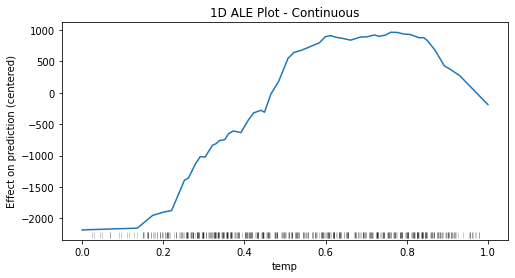

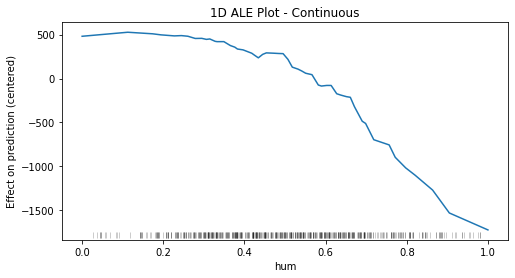

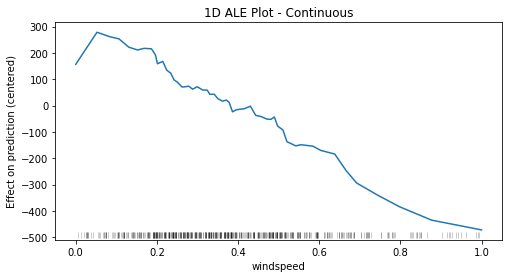

In [101]:
# fig, [ax1, ax2, ax3] = plt.subplots(nrows=1,ncols=3,figsize=(12,6))

ale_temp = ale(
    X=cleaned_bike_data, 
    model=rf, 
    feature=['temp'], 
    grid_size=50, 
    include_CI=False,
    # ax=ax1
)

ale_hum = ale(
    X=X_train, 
    model=rf, 
    feature=['hum'], 
    grid_size=50, 
    include_CI=False,
    # ax=ax2
)

ale_ws = ale(
    X=X_train, 
    model=rf, 
    feature=['windspeed'], 
    grid_size=50, 
    include_CI=False,
    # ax=ax3
)

PyALE._ALE_generic:INFO: Discrete feature detected.


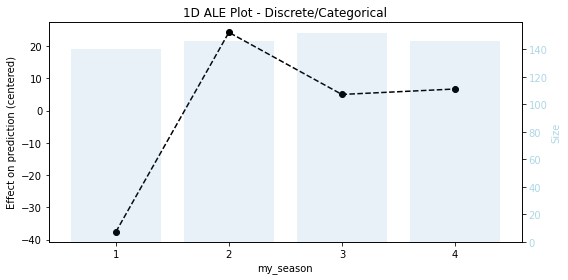

In [91]:
ale_eff = ale(
    X=X_train, 
    model=rf, 
    feature=['my_season'], 
    grid_size=50, 
    include_CI=False,
)

In [102]:
X_train.columns

Index(['temp', 'hum', 'windspeed', 'days_since_2011', 'season_SPRING',
       'season_SUMMER', 'season_WINTER', 'holiday_NO HOLIDAY',
       'workingday_WORKING DAY', 'weathersit_MISTY',
       'weathersit_RAIN/SNOW/STORM'],
      dtype='object')

In [ ]:
ale_eff = ale(
    X=X_train, 
    model=rf, 
    feature=[''], 
    grid_size=50, 
    include_CI=False,
)